In [34]:
import itertools
from copy import deepcopy as copy
from scipy.linalg import fractional_matrix_power, block_diag
import networkx as nx
import cvxpy as cp
import matplotlib as mpl
import matplotlib.pyplot as plt 
import numpy as np
from operator import itemgetter
# from netgraph import InteactiveGraph # pip install netgraph
from functools import reduce
import scipy 
from numpy.linalg import matrix_rank as rank 
from Adversary import Problem, to_str, visualize, Adversary, hamming_dist as dist
from Solvers import type_mask, partial, ket, instance_mask, adv_solver
from ElementDistinctness import ED
from Examples import exact_k, threshold_k
from time import time
from itertools import product, permutations
mpl.rcParams["figure.dpi"] = 120
from multiprocessing.pool import ThreadPool as Pool

In [35]:
def get_oracles(funcs, oracle_getter, to_list=True):
    print('get_oracles', len(funcs))
    if to_list:
        return [oracle_getter(func) for func in funcs]
    return {func: oracle_getter(func) for func in funcs}

def cycle_oracle(func):
    return permutation_oracle(cycle_to_standard(func))

def get_phase_oracles(problem):
    oracles = {}
    # roots = nthRootsOfUnity(n)
    if isinstance(problem, Problem):
        instances = problem.instances
    n = len(instances[0])
    for instance in instances:
        oracle = np.zeros((n,n))
        for i in range(n):
            oracle[i, i] =-1 if instance[i] == 1 else 1
        oracles[instance] = oracle
        
    return oracles
def phase_oracle(func):
    oracle = np.zeros((len(func),len(func)))
    for i in range(len(func)):
        oracle[i,i] = func[i]
    return oracle 
def get_standard_oracles(problem):
    oracles = {}
    n = problem.n
    alpha_len = len(problem.alphabet)
    for instance in problem.instances:
        oracle = []
        for i in range(n):
            curr_oracle = np.zeros((alpha_len, alpha_len))
            for a in problem.alphabet:
                curr_oracle[a, (instance[i] + a) % alpha_len] = 1
            # print(curr_oracle)
            oracle.append(copy(curr_oracle))
        oracles[instance] = block_diag(*oracle)
        # print(oracles[instance])
    return oracles
def standard_oracle(func, alpha_len=None):
    n = len(func)
    if alpha_len is None:
        alpha_len = n
    oracle = []
    for i in range(n):
        curr_oracle = np.zeros((alpha_len, alpha_len))
        for a in range(alpha_len):
            curr_oracle[a, (func[i] + a) % alpha_len] = 1
            # print(curr_oracle)
        oracle.append(copy(curr_oracle))
    return block_diag(*oracle)

def get_oracle_diffs(oracles, prod=True, mat=False, keys=None, threads=8):
    n=oracles[0].shape[0]
    if np.linalg.norm(np.imag(np.block([oracles]))) == 0:
        oracle_diffs = np.zeros([n * len(oracles)]*2)
    else:
        print("complex time!")
        oracle_diffs = np.zeros([n * len(oracles)]*2, dtype=complex)
    # print("keys", keys)
    I = np.eye(oracles[0].shape[0])
    if keys is None:
        keys = list(range(len(oracles)))
    # keys.sort()
    keys = list(range(len(oracles)))
    def diff_map(v):
        v1, v2 = v
        return I - oracles[v1].conj().T @ oracles[v2]
    # counter = 0
    pool = Pool(threads)
    for v1 in keys:
        if not v1 % 100:
            print(v1/len(oracles))
        oracle_diffs[v1*n:(v1+1)*n] = np.hstack(pool.map(diff_map, list(product([v1], keys))))
    return oracle_diffs
def phase_oracle_diffs(perms):
    # phase_mats = [permutation_oracle(perm) for perm in perms]
    diffs = [[_ for _ in range(len(perms))] for _2 in range(len(perms))]
    # print('diffs', diffs)
    n = len(perms[0])
    for i in range(len(perms)):
        for j in range(len(perms)):
            diff = np.zeros((len(perms[i]), len(perms[i])))
            for r in range(n):
                # for c in range(n):
                if perms[i][r] != perms[j][r]:
                    diff[r,r] = 1
            # print('ij', i, j)
            diffs[i][j] = diff
    return diffs
    
def permutation_oracle(perm, nonstandard=False):
    n = len(perm)
    
    oracle = np.zeros((n, n))
    for i in range(n):
        oracle[perm[i], i] = 1
    return oracle

def get_permutation_oracles(instances):
    # assuming instances are all lists representing permutations
    oracles = {}
    n = len(instances[0])
    print(n)
    # assert tuple(range(n)) == problem.alphabet
    for instance in instances:
        oracle = np.zeros((n, n))
        for i in range(n):
            oracle[i, instance[i]] = 1
        oracles[instance] = oracle
        # assert oracle@oracle.T - np.eye(n)
    return oracles

def preimage_even_odd(n):
    perms = itertools.permutations(range(n))
    no_instances = []
    yes_instances = []
    for perm in get_cycles(n,n):
        # print(to_str(perm))
        if perm.index(0) >= n//2:
            yes_instances.append(perm)
        else:
            no_instances.append(perm)
    return Problem(no_instances, yes_instances)

In [36]:
def search_perm_sorter(perms):
    n = len(perms[0])
    print('n', n)
    perm_types = {i:[] for i in range(n)}
    for perm in perms:
        perm_types[perm.index(0)].append( perm)
    for t in perm_types:
        perm_types[t].sort()
    perm_assignment = {}
    curr_perm = 0
    for i, permsi in perm_types.items():
        permsi = list(permsi)
        for perm in permsi:
            perm_assignment[perm] = curr_perm
            curr_perm += 1
    # print(perm_assignment)
    return perm_assignment, perm_types
# cycle_to_st
def search_mask(funcs, assignment=None, marker=0):
    size = len(funcs)
    if assignment is None:
        assignment = search_perm_sorter(funcs)
    if assignment == 'same':
        assignment = {funcs[i]: i for i in range(len(funcs))}
    # print(size)
    mask = np.zeros((size, size))
    for f in funcs:
        f0 = f.index(marker)
        for g in funcs:
            g0 = g.index(marker)
            if f0 != g0:
                mask[assignment[f], assignment[g]] = 1
    return mask
def index_or(n):
    funcs = list(set(itertools.permutations([1] + [0] * (n-1))))
    funcs.sort()
    print(funcs)
    size = len(funcs)
    return funcs, search_mask(funcs, assignment='same', marker=1)
# print(index_or(n))
def cycle_to_standard(cycle, nonstandard=True):
    n = len(cycle)
    if nonstandard:
        elements = list(cycle)
        elements.sort()
        cycle = tuple(elements.index(cycle[i]) for i in range(n))
    perm = list(range(n))
    for i in range(n):
        perm[cycle[i]] = cycle[(i+1)%n]
    return tuple(perm)
def get_shift(perm, k, l):
    # print(k,l)
    # take p_{k+1}->...->p_l and insert and put it at the end
    # cycle_perm = get_all_cycles(perm)[0]
    # print('get_all cycles', perm, cycle_perm)
    shifted_cycle = perm[:k+1] + perm[l+1:] + perm[k+1: l+1]
    # print('shift', cycle_perm, shifted_cycle)
    # print(k, l, cycle_perm, shifted_cycle)
    # print(k,l, get_all_cycles(cyclecycle_perm)[0], get_all_cycles(shifted_cycle))
    # print(shifted_cycle)
    # print(cycle_to_standard(shifted_cycle)
    assert len(perm) == len(shifted_cycle) 
    return shifted_cycle

def get_all_k_shift(perm, k):
    n = len(perm)
    # print('shift', list({get_shift(perm, k, j) for j in range(k+1, n-1)}))
    return list({get_shift(perm, k, j) for j in range(k+1, n-1) if perm[j][1]=='0'})

def get_n_cycles(n):
    cycles = itertools.permutations(range(n))
    perms = set()
    for cycle in cycles:
        perm = list(range(n))
        for i in range(n):
            perm[cycle[i]] = cycle[(i+1)%n]
        perms.add(tuple(perm))
    return list(perms)

def lv_search_mat(n, shift=None):
    cycles = get_n_cycles(n)
    # print(cycles)
    search_perm_sorter(cycles)
    assignment, perm_types = search_perm_sorter(cycles)
    one_pairs = dict()
    for cycle in cycles:
        # print(cycle)
        # print(get_all_k_shift(cycle))
        one_pairs[cycle] = []
        if shift is None:
            for k in range(1, n-1):
                one_pairs[cycle] = one_pairs[cycle] + get_all_k_shift(cycle, k)
        else: 
            one_pairs[cycle] = get_all_k_shift(cycle, shift)
    # print('pairs', one_pairs)
    mat = np.zeros((len(cycles), len(cycles)))
    for cycle in cycles:
        for pair in one_pairs[cycle]:
            # print(cycles, pair)
            mat[assignment[cycle], assignment[pair]] = 1
    return mat
    
def get_special_cycles(n, m, decision=False):
    perm_items = list(product(range(n), range(m)))
    # print(perm_items)
    index_cycles = get_cycles(n*m)
    # print('got all cycles')
    # print(index_cycles)
    preimage_dict = {str(y):[] for y in range(1, n)}
    cycles = [tuple(to_str(perm_items[index_cycle[i]]) for i in range(n*m)) for index_cycle in index_cycles]
    special_cycles = []
    # print(cycles)
    bad_cycles = []
    for cycle in cycles:
        if cycle[-1][1]=='0':
            # print(cycle)
            special_cycles.append(cycle)
            preimage_dict[cycle[-1][0]].append(cycle)
        else:
            bad_cycles.append(cycle)
    if decision:
        assignment_special = cycle_sort(special_cycles)
        assignment_bad = cycle_sort(bad_cycles)
        all_cycles = special_cycles + bad_cycles
        assignment = {all_cycles[i]: i for i in range(len(all_cycles))}
        preimage_dict = {0: special_cycles, 1: bad_cycles}
        return all_cycles, assignment, preimage_dict
    
    assignment = cycle_sort(special_cycles)
    for v, i in assignment.items():
        special_cycles[i] = v
    
    # print('returning special cycles')
    return special_cycles, assignment, preimage_dict
# phase_oracle_diffs([cycle_to_standard(cycle) for cycle in perms
def get_cycles(n):
    cycles = []
    for perm in permutations(range(1, n)):
        cycles.append((0,) + perm)
    return cycles
    
def to_str(l):
    return ''.join(str(a) for a in l)
    
def list_to_str(L):
    return [to_str(l) for l in L] 

def cycle_sort(cycles):
    cycles.sort(key=itemgetter(-1))
    return {cycles[i]: i for i in range(len(cycles))}

def shift(cycle, l, k):
    cycle2 = cycle[:k+1] + cycle[l+1:] + cycle[k+1:l+1]
    return cycle2

def mask_maker(assignment, cases):
    mat = np.zeros((len(assignment), len(assignment)))
    for case1 in cases:
        for case2 in cases:
            if case1 != case2:
                for perm1 in cases[case1]:
                    for perm2 in cases[case2]:
                        # print('cases', case1, case2)
                        # print('perms',perm1, perm2)
                        mat[assignment[perm1], assignment[perm2]] = 1
    return mat

def function_erasure_mask(funcs, target=0):
    n = len(funcs[0])
    start_vects = []
    end_vects = []
    for func in funcs:
        inv = func.index(target)
        end_vect = np.zeros((n, n)) 
        end_vect[:, 0] = 1
        end_vect[inv,0] = 0
        start_vect = np.zeros((n,n))
        for i in range(n):
            if i != inv:
                start_vect[i, func[i]] = 1
        start_vects.append(start_vect)
        end_vects.append(end_vect)
    mask = np.zeros((len(funcs), len(funcs)))
    for i in range(len(funcs)):
        # print(start_vects[i])
        for j in range(len(funcs)):
            # print(end_vects[i])
            mask[i,j] = np.trace(start_vects[i].T@start_vects[j]) - np.trace(end_vects[i].T@end_vects[j])
    return mask
def nthRootsOfUnity2(n): # constant space, serial
    from cmath import exp, pi
    c = 2j * pi / n
    return [exp(k * c) for k in range(n)]
def real_phase_oracle(func):
    n = len(func)
    roots = nthRootsOfUnity2(n)
    # print(roots)
    oracle = np.zeros((n,n), dtype=complex)
    for i in range(n):
        oracle[i,i] = roots[func[i]]
    return oracle

def unitary_implementation(problem_mats):
    # problem_dict[i]=(oracle_i, unitary_i)
    n = problem_mats[0][0].shape[0]
    problem_index_to_label = list(product(range(len(problem_mats)), range(n)))
    label_to_index = {problem_index_to_label[i]: i for i in range(len(problem_mats))}
    size = len(problem_index_to_label)
    problem_mask = np.zeros((size, size), dtype=complex)
    print(problem_index_to_label)
    start_end_vectors = []
    for oracle, unitary in problem_mats:
        for i in range(n):
            start_end_vectors.append(((np.eye(1, n, i).T).T, (unitary@np.eye(1, n, i).T).T))
    
    for i in range(size):
        for j in range(size):
            start_i, end_i = start_end_vectors[i]
            start_j, end_j = start_end_vectors[j]    
            
            problem_mask[i,j] = np.inner(np.conj(start_i), start_j)[0,0] - np.inner(np.conj(end_i), start_j)[0,0]
    oracles_for_diff = [problem_mats[i][0] for _ in range(n) for i in range(len(problem_mats))]
    diffs = get_oracle_diffs(oracles_for_diff)
    return problem_mask, diffs

def relative_hadamard_norm_max(mat, relative_mat, D_len, solver="MOSEK", uni=True, threads=8, extra_constraints=None):
    print('shapes', )
    relative_shape = [0,0]
    relative_shape[0] = relative_mat.shape[0] // mat.shape[0]
    relative_shape[1] = relative_mat.shape[1] // mat.shape[1]
    relative_shape = tuple(relative_shape)
    
    # print(D1_len, len(D2), relative.shape)
    # relative_mat = np.block(relative)

    print(relative_mat.shape)
    Y = cp.Variable((D_len, D_len), hermitian=True)
    Lambda = cp.Variable((D_len, D_len), hermitian=True)
    print(relative_shape)
    Lambda_relative = cp.kron(Lambda, np.ones(relative_shape))
    Lambda_relative = cp.multiply(Lambda_relative, relative_mat)
    diag = cp.kron(cp.diag(cp.diag(Y)), np.eye(relative_shape[0]))
    if not uni:
        Lambda_relative = cp.bmat([
            [np.zeros(Lambda_relative.shape), Lambda_relative],
            [Lambda_relative.H, np.zeros(Lambda_relative.shape)] 
        ])
        diag = cp.kron(diag, np.eye(2))
    # print(W.shape, diag.shape)
    # W = Lambda_relative - diag
    # print(W)
    constraints = [cp.trace(Y) == 1, Lambda_relative << diag]
    if extra_constraints is not None:
        constraints = constraints + [eval(constraint) for constraint in extra_constraints]
        
    opt_prob = cp.Problem(cp.Maximize(2 * cp.sum(cp.real(cp.multiply(Lambda.T, mat)))), constraints)
    opt_prob.solve(verbose=True, solver=solver, mosek_params= {"MSK_IPAR_NUM_THREADS": threads})
    # opt_prob.solve(verbose=True, solver="SCS")
                # eps_rel=1e-4,
                # eps_infeas=1e-7)
    return Lambda.value, Y.value, Lambda_relative.value


def to_adversary_mat(Lambda, mu):
    G = np.zeros(Lambda.shape)
    for x in range(Lambda.shape[0]):
        for y in range(Lambda.shape[1]):
            G[x,y] = Lambda[x,y]/np.sqrt(mu[x,x] * mu[y,y])
            
    return G

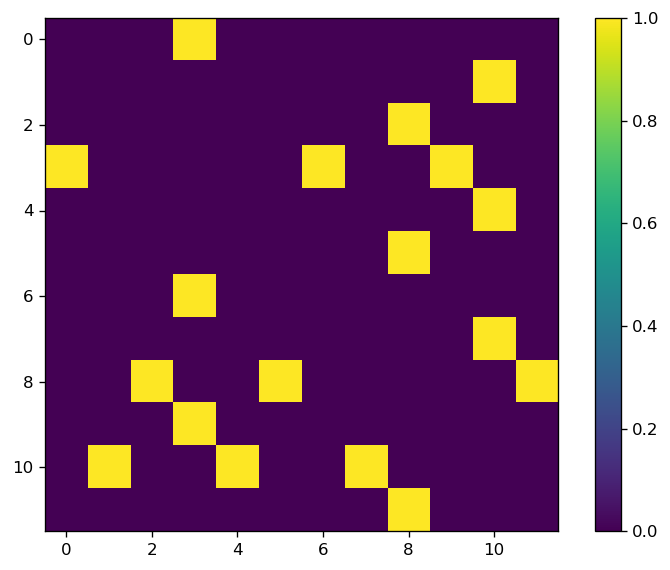

shapes
(12, 12)
(3, 3)
                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) Nov 11 01:08:46 PM: Your problem has 32 variables, 2 constraints, and 0 parameters.
(CVXPY) Nov 11 01:08:46 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Nov 11 01:08:46 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Nov 11 01:08:46 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Nov 11 01:08:46 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Nov 11 01:08:46 PM: Compiling problem (ta

C:\Users\Blake\AppData\Local\Temp\ipykernel_31228\3432883558.py:268: ComplexWarning: Casting complex values to real discards the imaginary part
  G[x,y] = Lambda[x,y]/np.sqrt(mu[x,x] * mu[y,y])


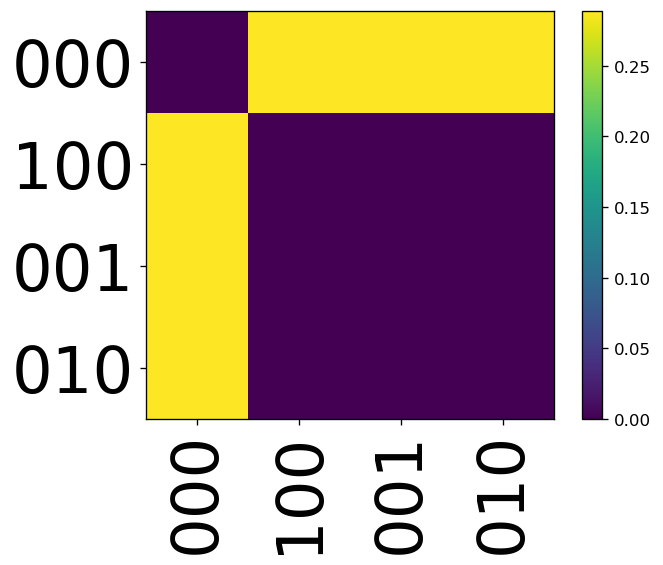

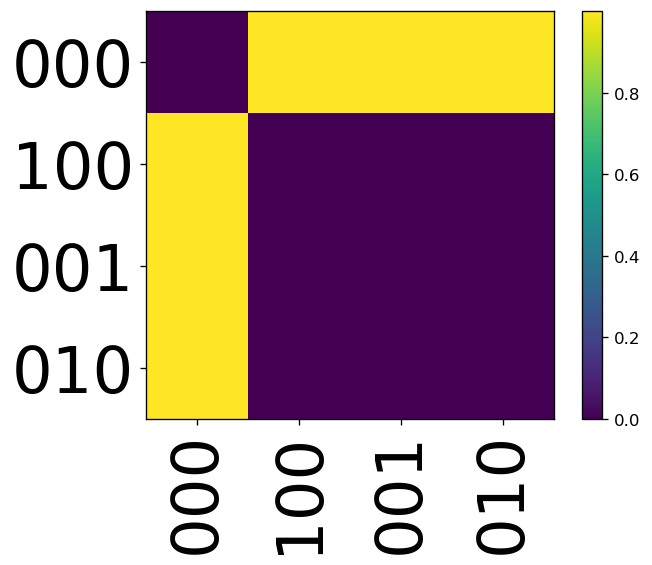

[-5.00000000e-01 -1.28420563e-20  1.28420563e-20  5.00000000e-01]
[-1.73205081e+00 -7.70529079e-20  7.70529079e-20  1.73205081e+00]


In [37]:
n = 3
k = 1
prob = threshold_k(n, k)
oracle_diffs = phase_oracle_diffs(prob.instances)
oracle_diffs = np.block(oracle_diffs)
labels = list_to_str(prob.instances)
labels = [labels]*2
visualize(oracle_diffs)
mask = type_mask(prob)
# visualize(mask, labels)
L, Y, R = relative_hadamard_norm_max(mask, oracle_diffs, len(prob.instances))
G = to_adversary_mat(L, Y)
visualize(L, labels)
visualize(G, labels)
print(np.linalg.eigvalsh(L))
print(np.linalg.eigvalsh(G))

getting special cycles
len 6
get_oracles 6
diffs
0.0
mask
cycle_labels
diff_labels


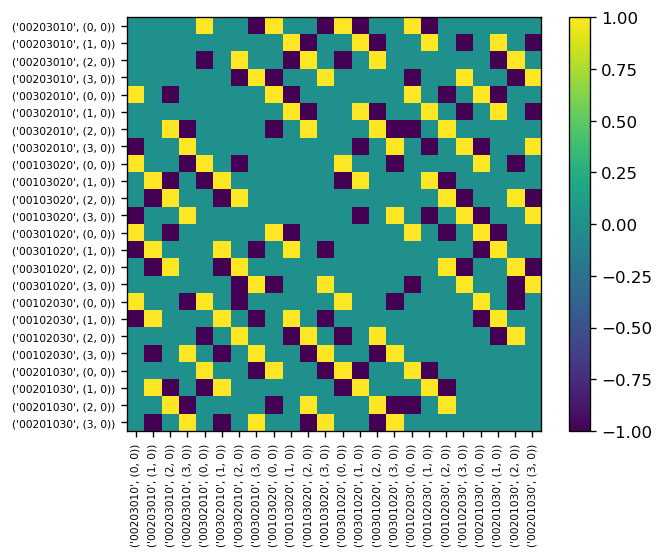

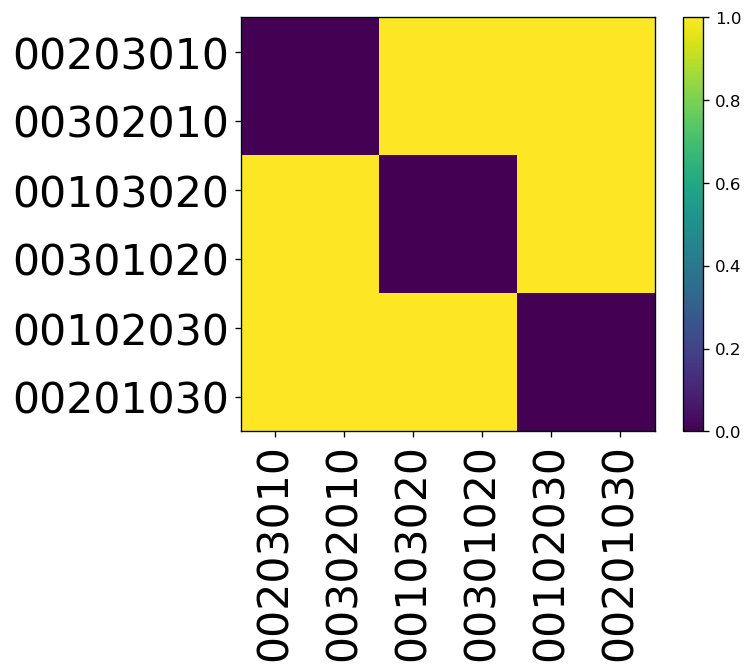

shapes
(24, 24)
(4, 4)
                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) Nov 11 01:30:38 PM: Your problem has 72 variables, 2 constraints, and 0 parameters.
(CVXPY) Nov 11 01:30:38 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Nov 11 01:30:38 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Nov 11 01:30:38 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Nov 11 01:30:38 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Nov 11 01:30:38 PM: Compiling problem (ta

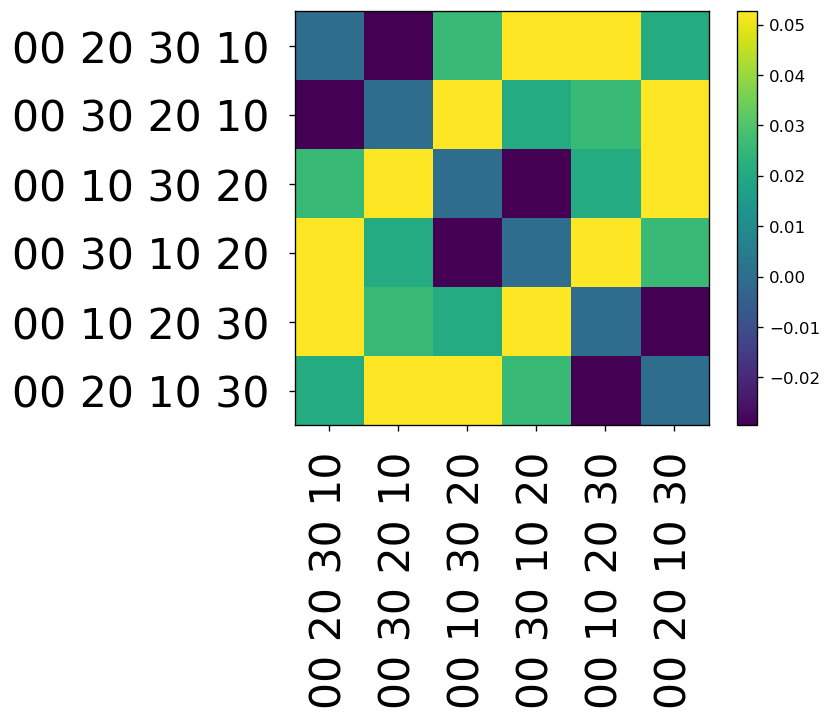

C:\Users\Blake\AppData\Local\Temp\ipykernel_31228\3432883558.py:268: ComplexWarning: Casting complex values to real discards the imaginary part
  G[x,y] = Lambda[x,y]/np.sqrt(mu[x,x] * mu[y,y])


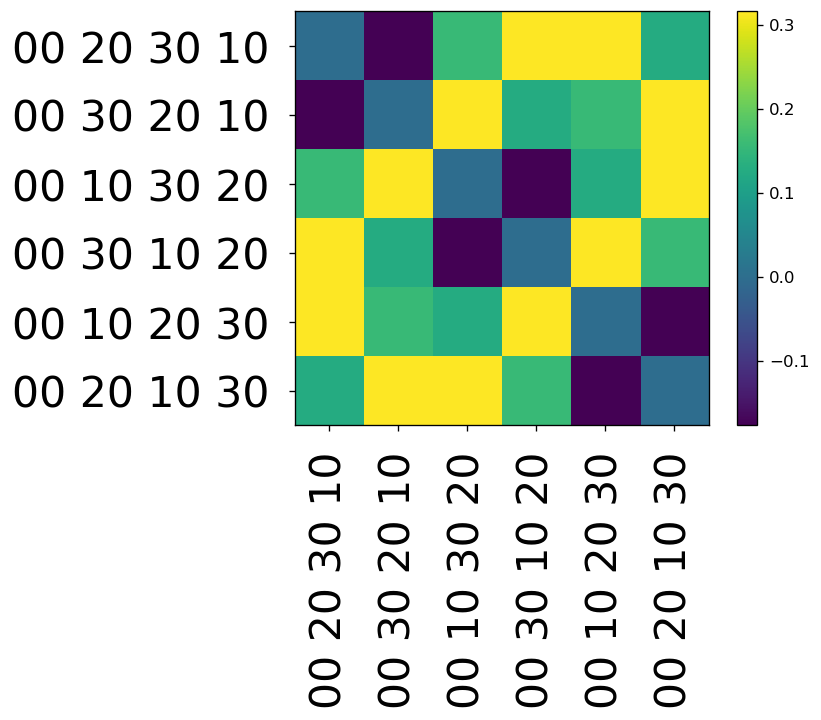

In [67]:
n=4
m=1
print('getting special cycles')
cycles, assignment, preimage_dict = get_special_cycles(n, m)
standard = [cycle_to_standard(cycle) for cycle in cycles]
# print('len1', len(cycles))
# np.random.shuffle(cycles)
# cycles = cycles[:len(cycles)//10]
print('len', len(cycles))
oracles = get_oracles(cycles, cycle_oracle)
print('diffs')
diffs = get_oracle_diffs(oracles)
# diffs = np.block(phase_oracle_diffs(standard))
print('mask')
problem_mask = mask_maker(assignment, preimage_dict)
print('cycle_labels')
cycle_labels = [to_str(cycle) for cycle in cycles]
better_labels = [' '.join(label[i:i+2] for i in range(0,len(label)+1, 2)) for label in cycle_labels] 

print('diff_labels')
# print(cycle_labels)
diff_labels = list(product(cycle_labels, product(range(n), range(m))))
visualize(diffs, (diff_labels, diff_labels))
visualize(problem_mask, (cycle_labels, cycle_labels))
Lambda, Y, W = relative_hadamard_norm_max(problem_mask, diffs, problem_mask.shape[0], uni=True)
visualize(np.real(Lambda), [better_labels]*2)
visualize(to_adversary_mat(Lambda, Y),[better_labels]*2)


getting shifted k= 0
('00', '20', '30', '10')
filling matrix
getting shifted k= 1
('00', '20', '30', '10')
filling matrix
getting shifted k= 2
('00', '20', '30', '10')
filling matrix
mask?


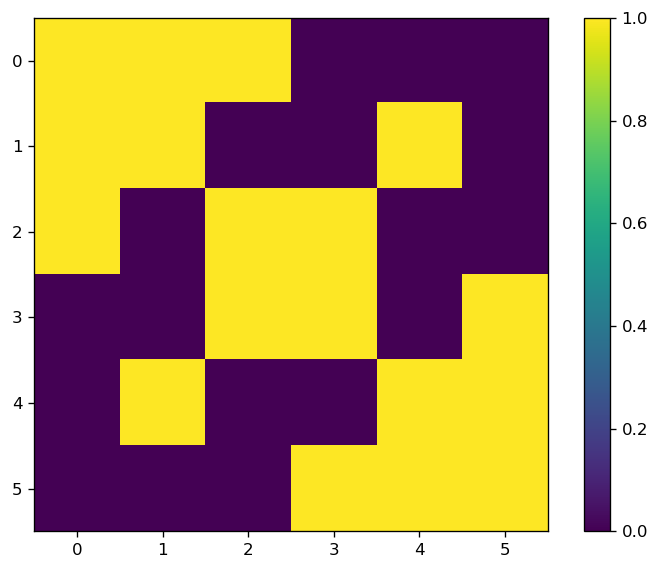

                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) Nov 11 04:25:32 PM: Your problem has 36 variables, 1 constraints, and 0 parameters.
(CVXPY) Nov 11 04:25:32 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Nov 11 04:25:32 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Nov 11 04:25:32 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Nov 11 04:25:32 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Nov 11 04:25:32 PM: Compiling problem (target solver=MOSEK).
(CV

In [95]:
def adversary_k(cycles, k):
    print('getting shifted', 'k=', k)
    print(cycles[0])
    cycle_set = {tuple(cycle) for cycle in cycles}
    shifted = {cycle: get_all_k_shift(cycle, k) for cycle in cycles}
    shift_mat = np.zeros((len(cycles), len(cycles))) 
    print('filling matrix')
    curr_cycle = 0
    for cycle, shifts in shifted.items():
        if len(shifted)>= 10 and not curr_cycle % (len(shifted) // 10):
            print( np.round(curr_cycle /len(shifted), 3), end=' ')
        curr_cycle += 1
        for shift in shifts:
            # print(cycle, shift)
            shift_mat[cycles.index(cycle), cycles.index(shift)] = 1
    return shift_mat


def min_fill(adv, diffs, mask=None):
    n = diffs.shape[0] // adv.shape[0] 
    if mask is None:
        mask = np.zeros(adv.shape)
        for i in range(mask.shape[0]):
            for j in range(mask.shape[1]):
                if adv[i,j] == 0:
                    mask[i,j] = 1
    print('mask?')
    visualize(mask)
    extra = cp.Variable(adv.shape, symmetric=True)
    constraints = [cp.multiply(mask, extra) == extra]
    adv_diff = cp.multiply(cp.kron((adv + extra), np.ones((n,n))), diffs)
    val = np.linalg.eigvalsh(np.kron(adv, np.ones((n,n)))* diffs)[-1]
    opt_prob = cp.Problem(cp.Minimize(cp.lambda_max(adv_diff)), constraints)
    opt_prob.solve(verbose=True)
    return extra.value, adv_diff.value
def partial(instances, i):
    lang_size = len(instances)
    D = np.zeros((lang_size, lang_size))
    for j in range(lang_size):
        for k in range(lang_size):
            yes = instances[j]
            no = instances[k]
            if yes[i] != no[i]:
                D[j ][k] = 1
                D[k][j] = 1 
    return D
    
advs = [adversary_k(cycles, i) for i in range(0,n*m-1)]
adv_k = np.sum([adv for adv in advs], axis=0) 
# adv = Adversary(Problem([cycles[0]], cycles[1:]), matrix=adv_k)
# for adv in advs:
    # visualize(adv, [better_labels]*2)
# visualize(adv_k, (cycles, cycles))
# visualize(np.where(rounded_lambda<=vals[-2], 1, 0), [better_labels]*2)
extra, adv_diff = min_fill(adv_k, diffs)
# visualize(extra, (cycle_labels, cycle_labels))
# visualize(adv_diff)


# visualize(extra)
# visualize(diff)

2.0


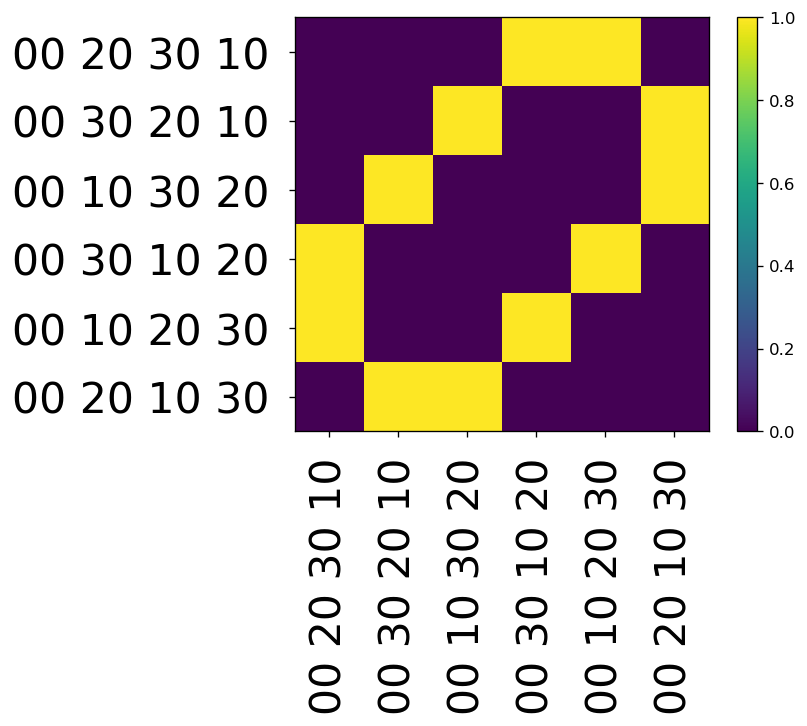

2.3913823806309016


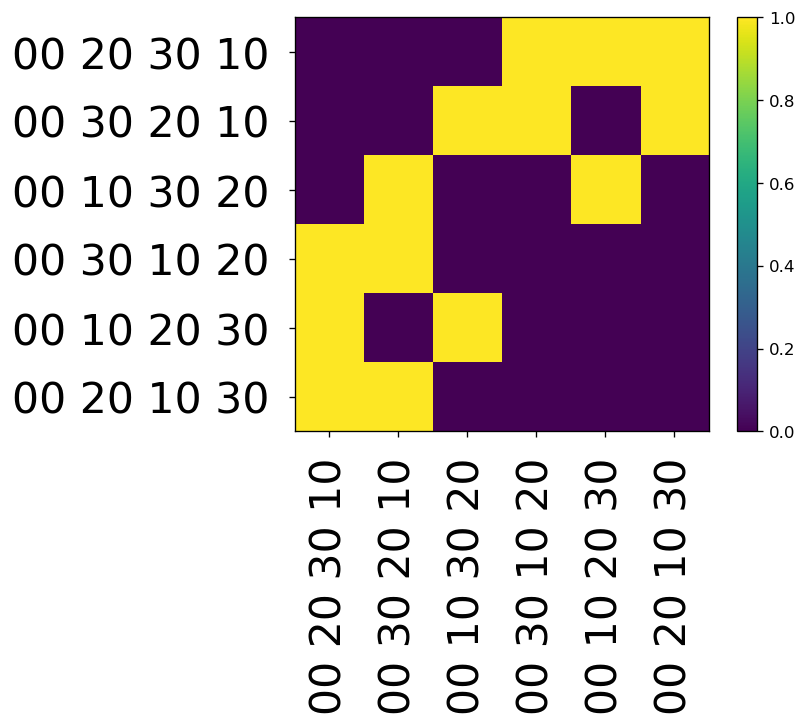

2.391382380630901


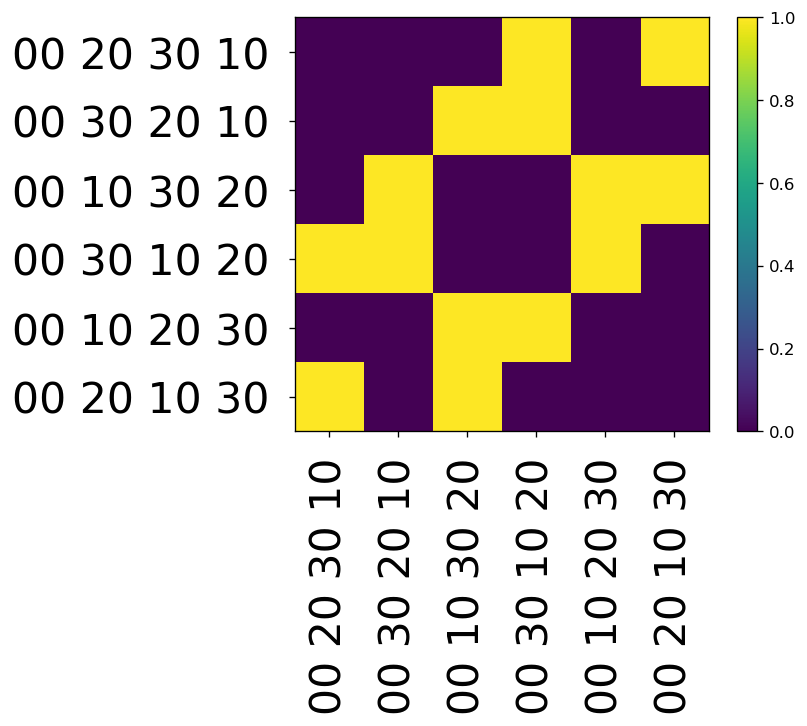

2.3913823806308994


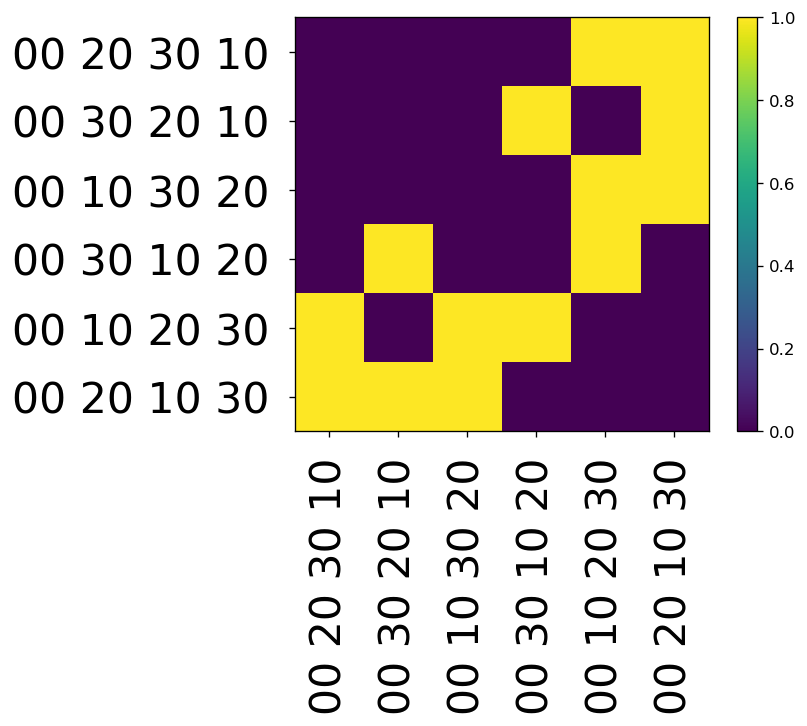

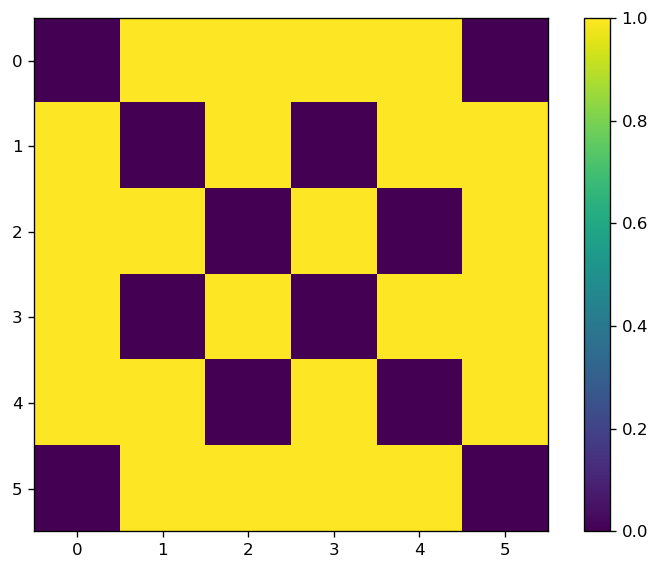

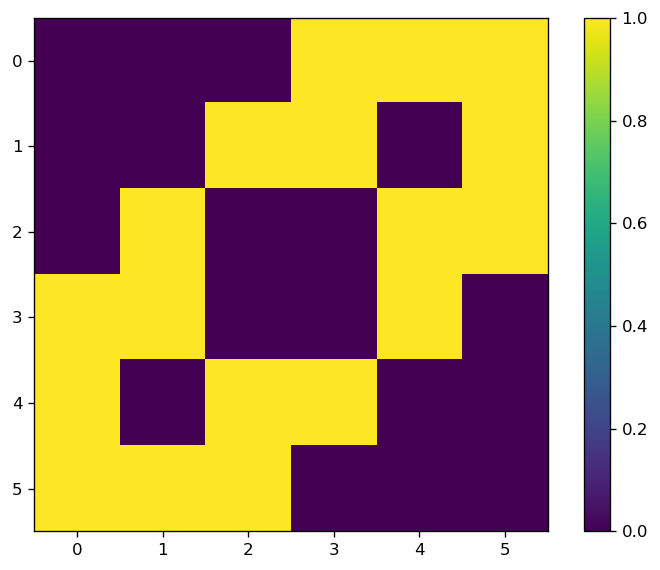

orig 2.0
                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) Nov 11 04:29:14 PM: Your problem has 36 variables, 1 constraints, and 0 parameters.
(CVXPY) Nov 11 04:29:14 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Nov 11 04:29:14 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Nov 11 04:29:14 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Nov 11 04:29:14 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Nov 11 04:29:14 PM: Compiling problem (target solver=MO

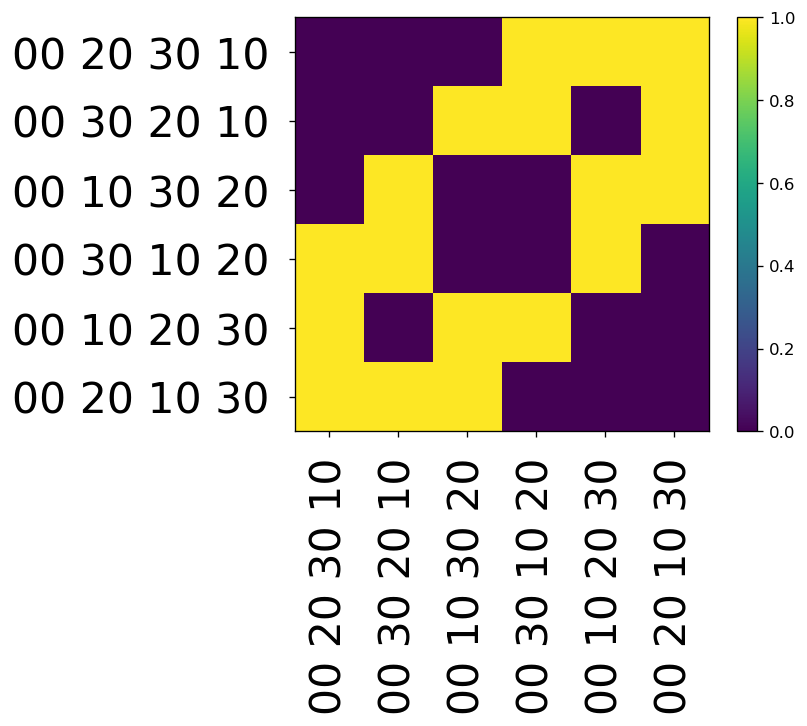

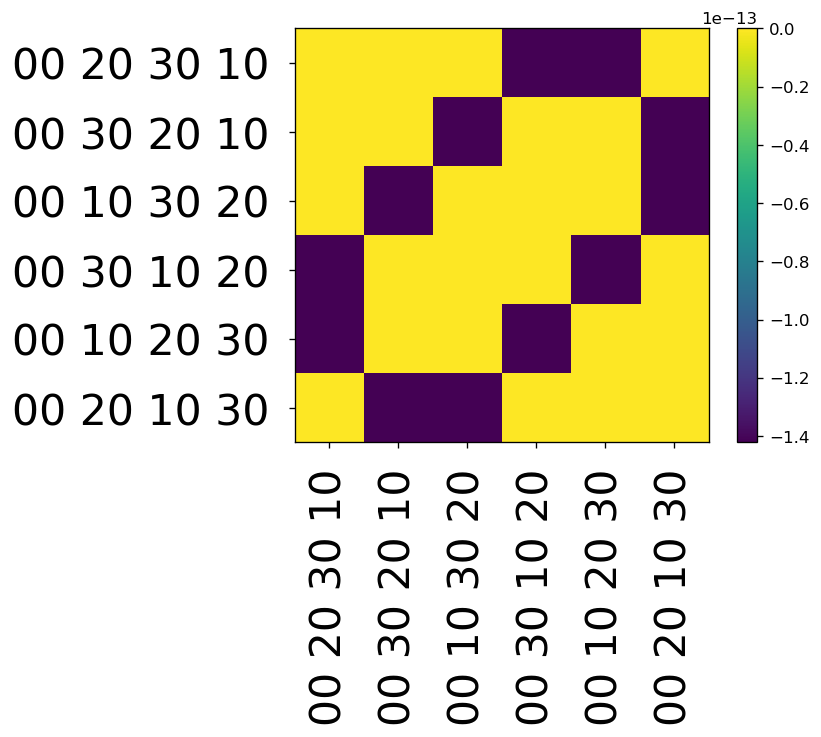

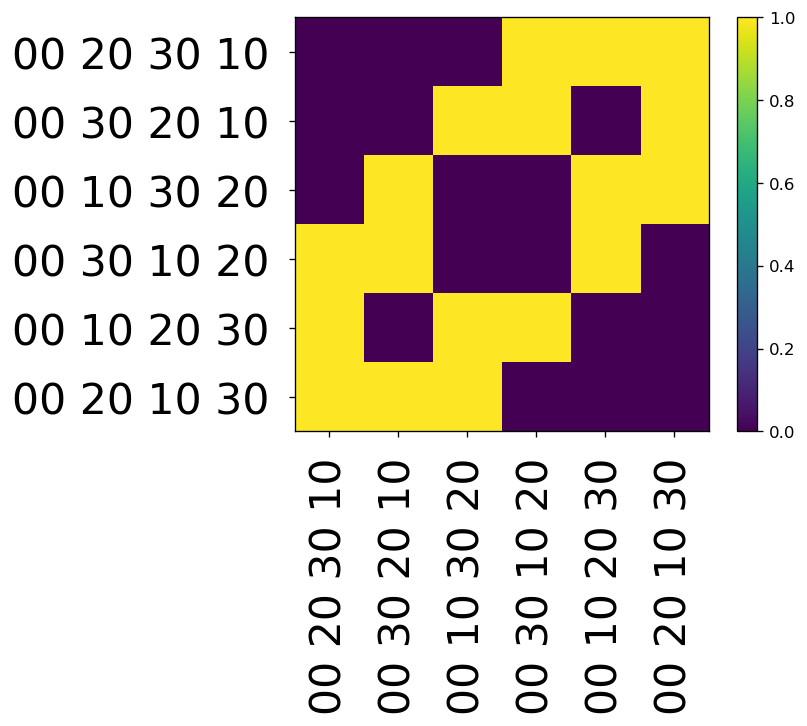

ValueError: The number of FixedLocator locations (6), usually from a call to set_ticks, does not match the number of labels (24).

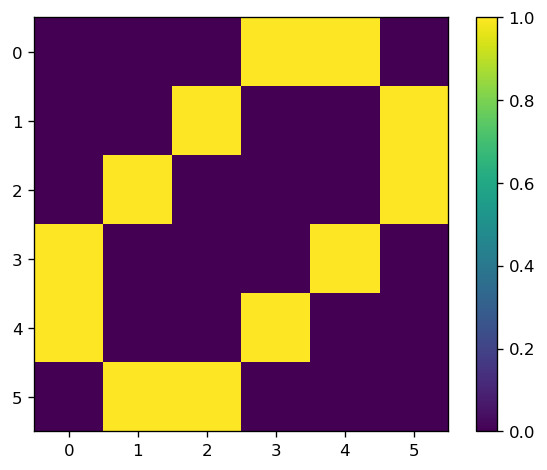

In [98]:
def min_relative_lmax_completion(mat, relative, allowable_mask):
    comp = cp.Variable(mat.shape, symmetric=True)
    constraints = [cp.multiply(comp, allowable_mask) == comp]
    completed = mat + comp  
    increase_shape = [relative.shape[0] // mat.shape[0]]*2
    completed_big = cp.kron(completed, np.ones(increase_shape))
    orig_eval = np.linalg.eigvalsh(np.kron(mat, np.ones(increase_shape))* relative)[-1]
    print('orig', orig_eval)
    completed_big_rel = cp.multiply(completed_big, relative)
    opt_prob = cp.Problem(cp.Minimize(cp.lambda_max(completed_big_rel)), constraints)
    opt_prob.solve( solver="MOSEK", verbose=True)
    print('after', opt_prob.value)
    return comp.value, completed.value, completed_big_rel.value
phase_diffs = np.where(diffs>0, diffs, 0)
part = partial(standard, 0)
for i in range(n*m):
    print(np.max(np.linalg.eigvalsh(adv_k*partial(standard, i))))
    visualize(adv_k*partial(standard, i), [better_labels]*2)
phase_diffs = part
visualize(phase_diffs)
visualize(adv_k)
comp, completed, completed_big_rel = min_relative_lmax_completion(adv_k, phase_diffs, np.ones(problem_mask.shape) - problem_mask)
bl = [better_labels]*2
print(np.linalg.eigvalsh(adv_k))
print(np.linalg.eigvalsh(adv_k*phase_diffs))
visualize(adv_k, bl)
visualize(comp, bl)
visualize(completed, bl)
visualize(completed_big_rel, [list(product(better_labels, range(n*m)))]*2)


In [64]:
def visualize_outers(mat, row_labels=None):
    if row_labels is None:
        row_labels = list(range(mat.shape[0]))
    vals, vects, outers = get_eig_outer(mat)
    vals = np.round(vals, 4)
    vals_str = [str(val) for val in vals]
    for val, outer in zip(vals, outers):
        visualize(outer, labels=(vals_str, row_labels), title=str(val))

In [65]:
# import math

# y=4
# print(y_adv)
# print(cycle_labels)
# print(better_labels)
G = nx.from_numpy_array(adv_k)
G = nx.relabel_nodes(G, {i: better_labels[i] for i in range(len(better_labels))})
# nx.draw(G, with_labels=True)
# largest_components=sorted(nx.connected_components(G), key=len, reverse=True)[:n]
# for index,component in enumerate(largest_components):
#     S = G.subgraph(component)
#     nx.draw(S, pos=nx.spring_layout(S, k=100), node_size=1000, with_labels=True)
#     plt.show()
# print(np.array([len(list(G.neighbors(label))) for label in cycle_labels]))
# c = np.argmax(np.array([len(list(G.neighbors(label))) for label in cycle_labels]))
# print(c)
# c=0
print('defining pairs')
pairs = list([u,v ] for u,v in product(better_labels, better_labels) if u!=v and u[-3:]==v[-3:])
print(pairs[:5])
print(len(pairs))
print('findng common')
neighs = np.zeros(len(pairs))
for i in range(len(pairs)):
    if len(pairs) >= 50 and not i % (len(pairs) // 50):
        print(np.round(i/len(pairs),3), end=' ')
    neighs[i] = len(nx.common_neighbors(G, *pairs[i]))
# print(neighs)
most_common_neigh = np.argmax(neighs)

defining pairs
[]
0
findng common


ValueError: attempt to get argmax of an empty sequence

In [66]:
# most_common_neigh = 3
# print(common_neigh)
common_neigh = nx.common_neighbors(G, *pairs[most_common_neigh])
plt.margins(x=0.3,y=.3)
fig = plt.gcf()
fig.set_size_inches(10, 10)
# print(pairs[most_common_neigh])
# print(list(G.neighbors(pairs[most_common_neigh][0])))
# print(list(G.neighbors(pairs[most_common_neigh][1])))
print(pairs[most_common_neigh])
S = nx.induced_subgraph(G, list(common_neigh) )
# print(cycles[c])
nx.draw(S, with_labels=True, pos=nx.shell_layout(S), node_size=100)


IndexError: list index out of range

[2. 2. 2. 2. 2. 2.]


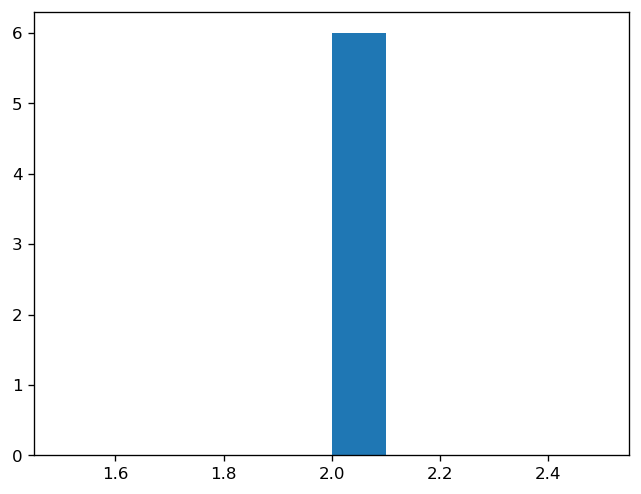

In [32]:
size = int(np.sqrt(len(pairs)))+1
plt.hist(neighs)
print(neighs)
# print(size, )
# fig, axes = plt.subplots(size, size, figsize=(4*size,4*size), dpi=100)
# axes = axes.flatten()
# for i in range(len(pairs)):
#     print(i, end=' ')
#     common_neigh = nx.common_neighbors(G, *pairs[i])
#     S = nx.induced_subgraph(G, list(common_neigh))
#     nx.draw(S, with_labels=True, ax=axes[i])
#     axes[i].margins(.4,.4)
#     axes[i].set_title(', '.join(pairs[i]))
# print()
# plt.ion()
# fig.canvas.draw()

# for ii, ax in enumerate(axes):

#     print(ii, end=' ')
#     bbox = ax.get_tightbbox(fig.canvas.get_renderer())
#     x0, y0, width, height = bbox.transformed(fig.transFigure.inverted()).bounds
#     # slightly increase the very tight bounds:
#     xpad = 0.05 * width
#     ypad = 0.05 * height
#     fig.add_artist(plt.Rectangle((x0-xpad, y0-ypad), width+2*xpad, height+2*ypad, edgecolor='grey', linewidth=3, fill=False))

# # fig.savefig(str(n) + ',' + str(m) +".pdf")


30
[(2, 0, 3, 1), (3, 0, 1, 2), (1, 3, 0, 2), (3, 2, 0, 1), (1, 2, 3, 0), (2, 3, 1, 0)]


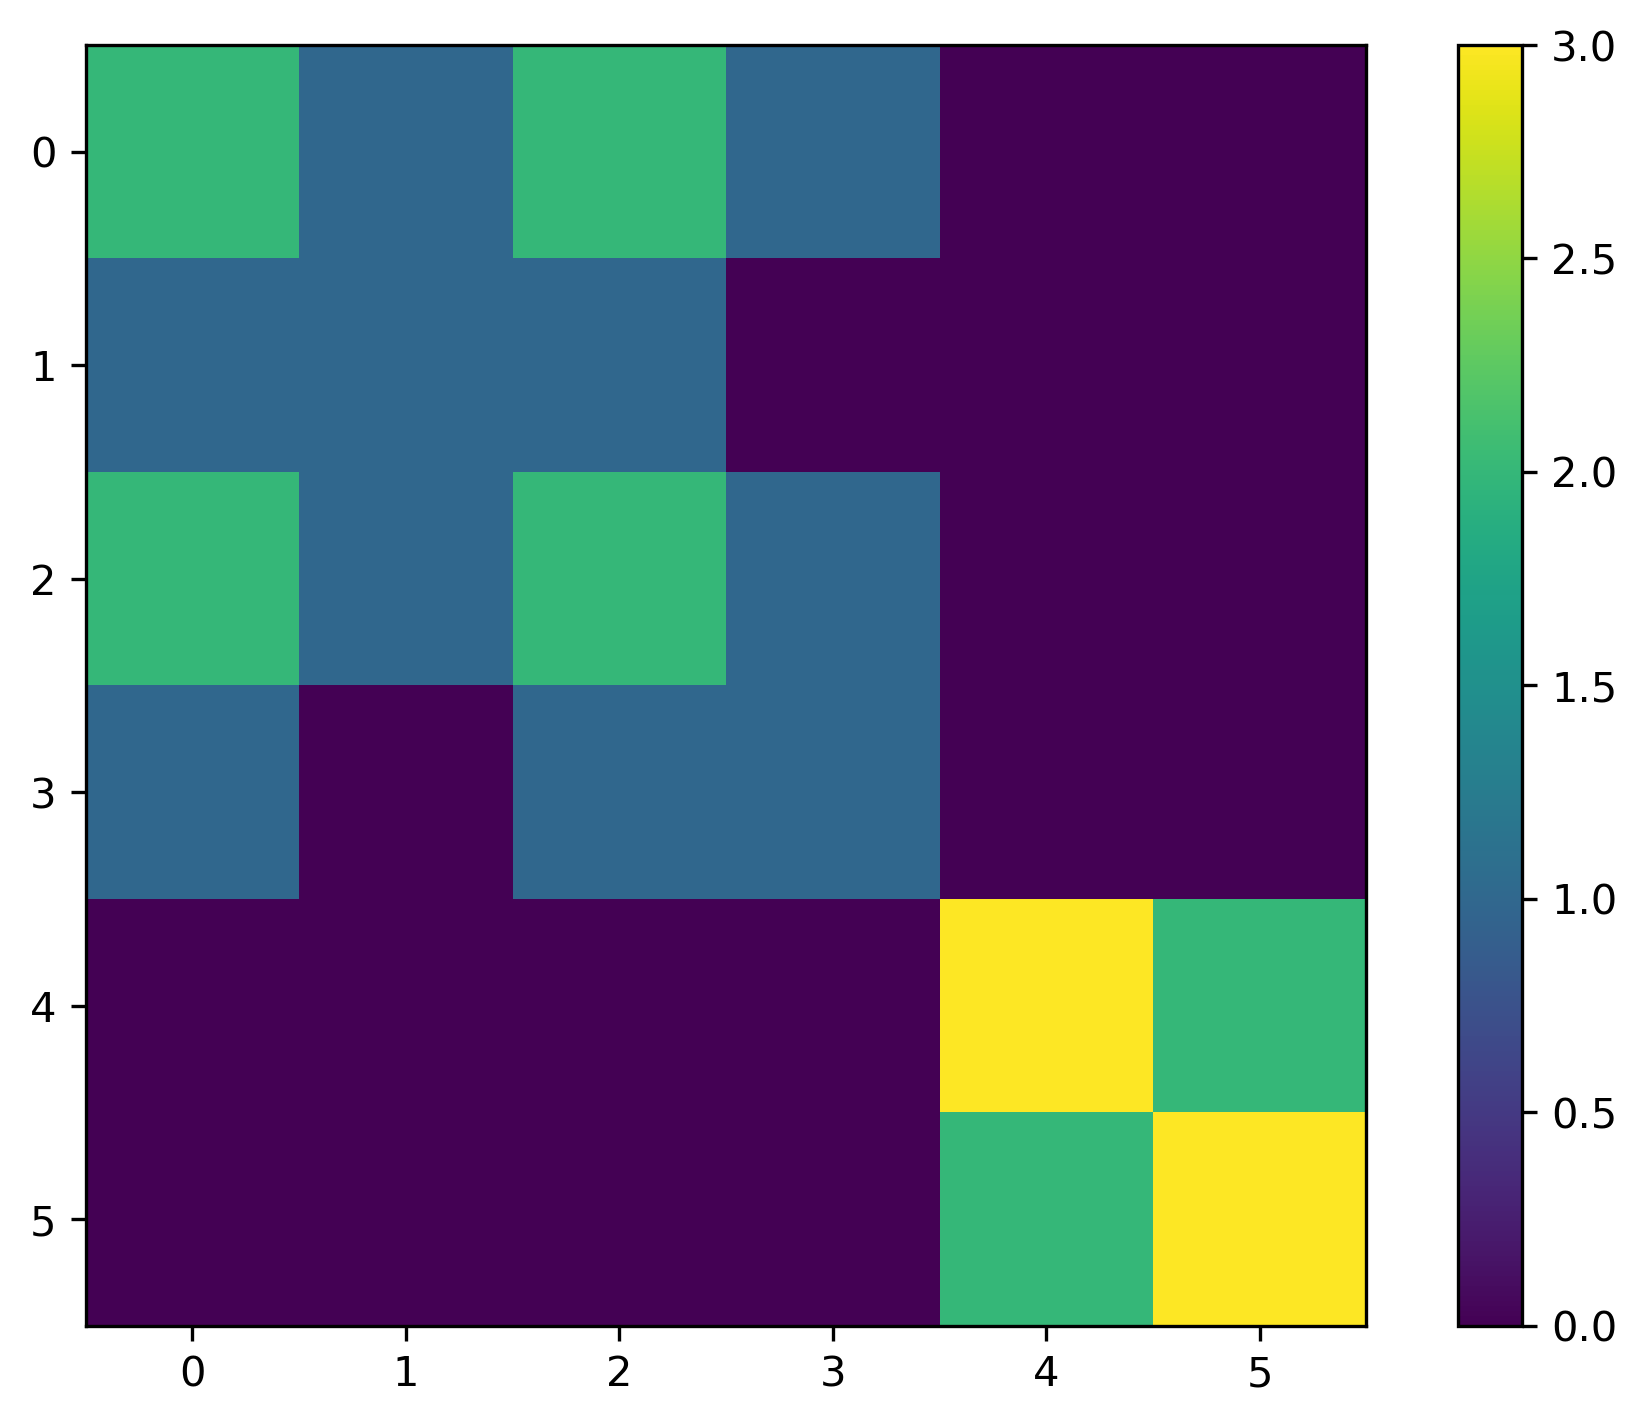

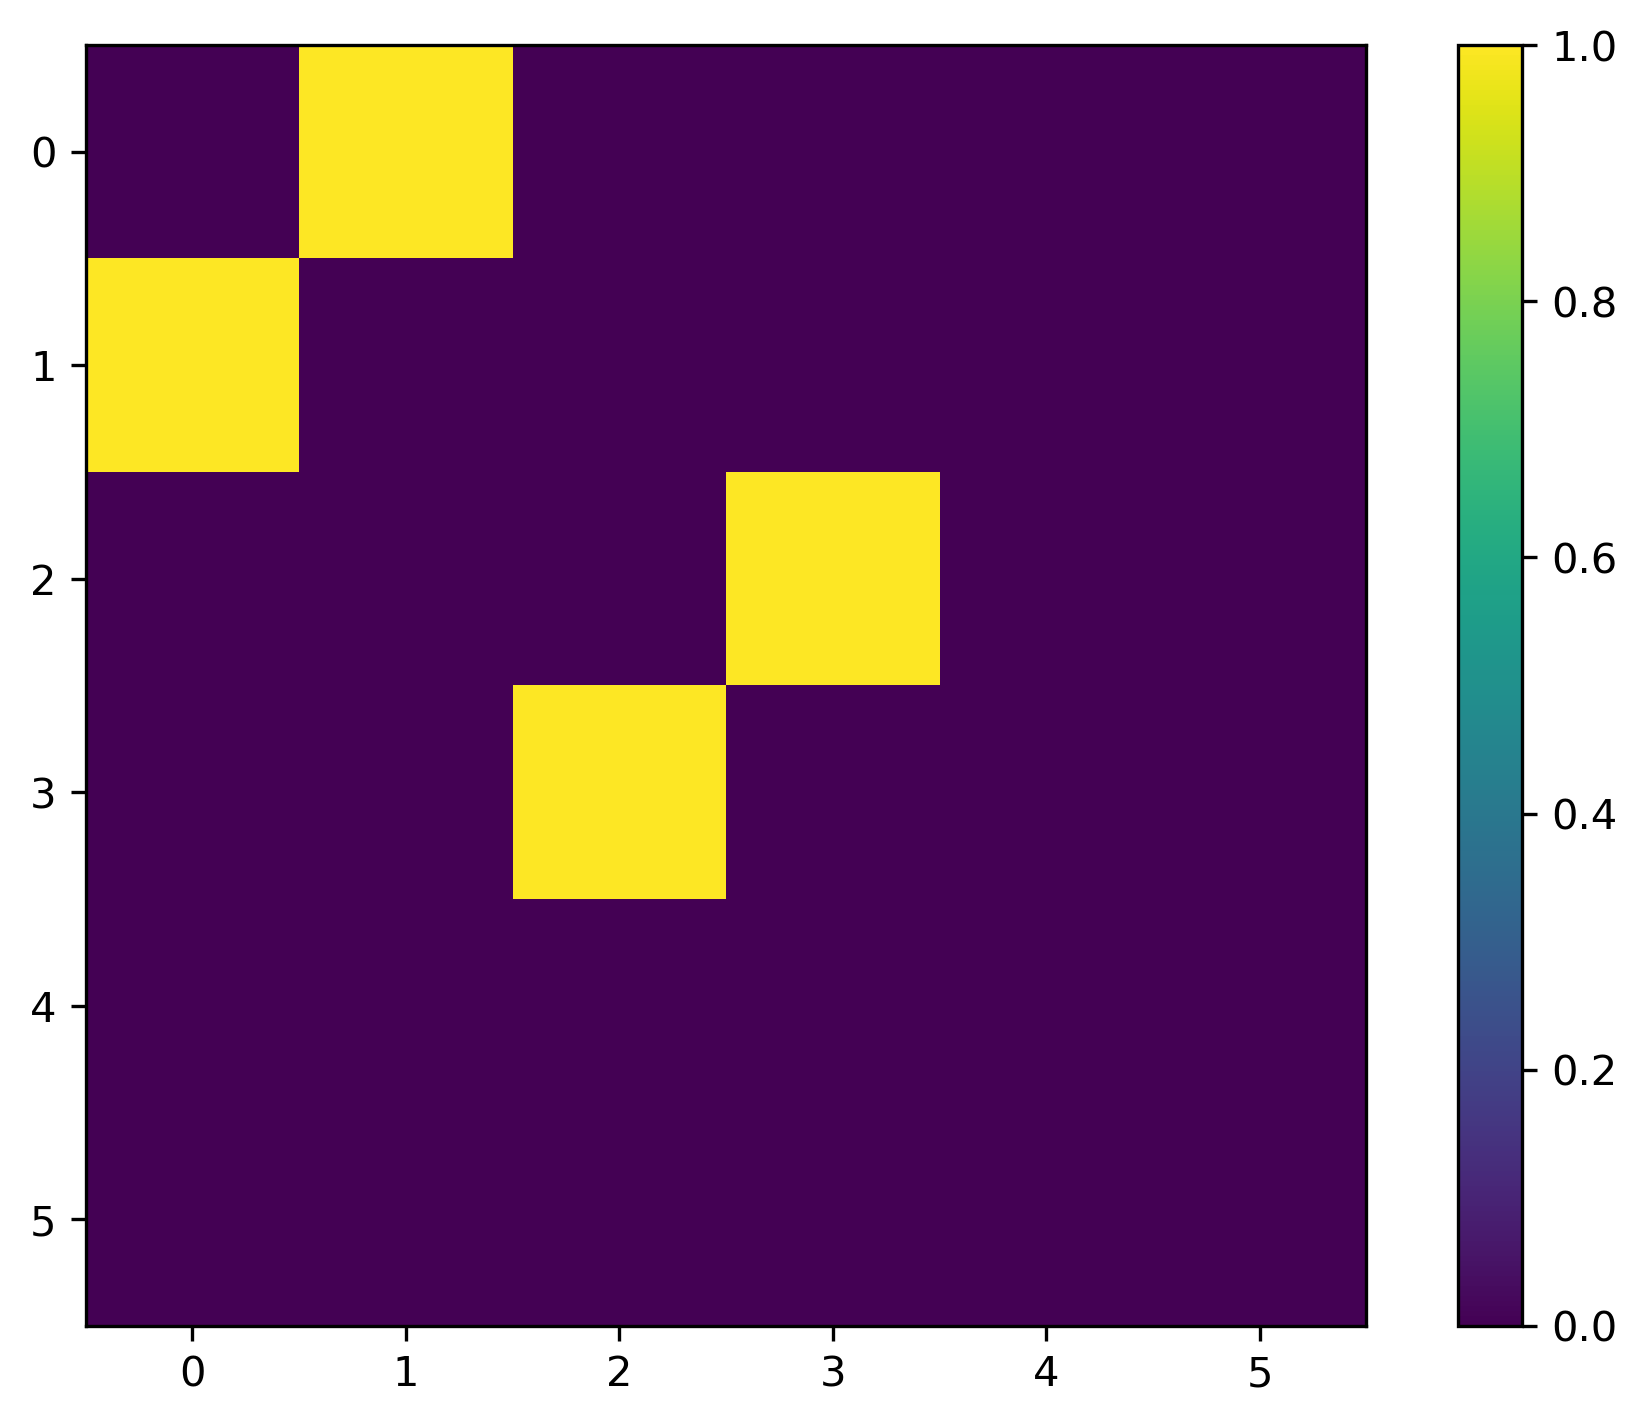

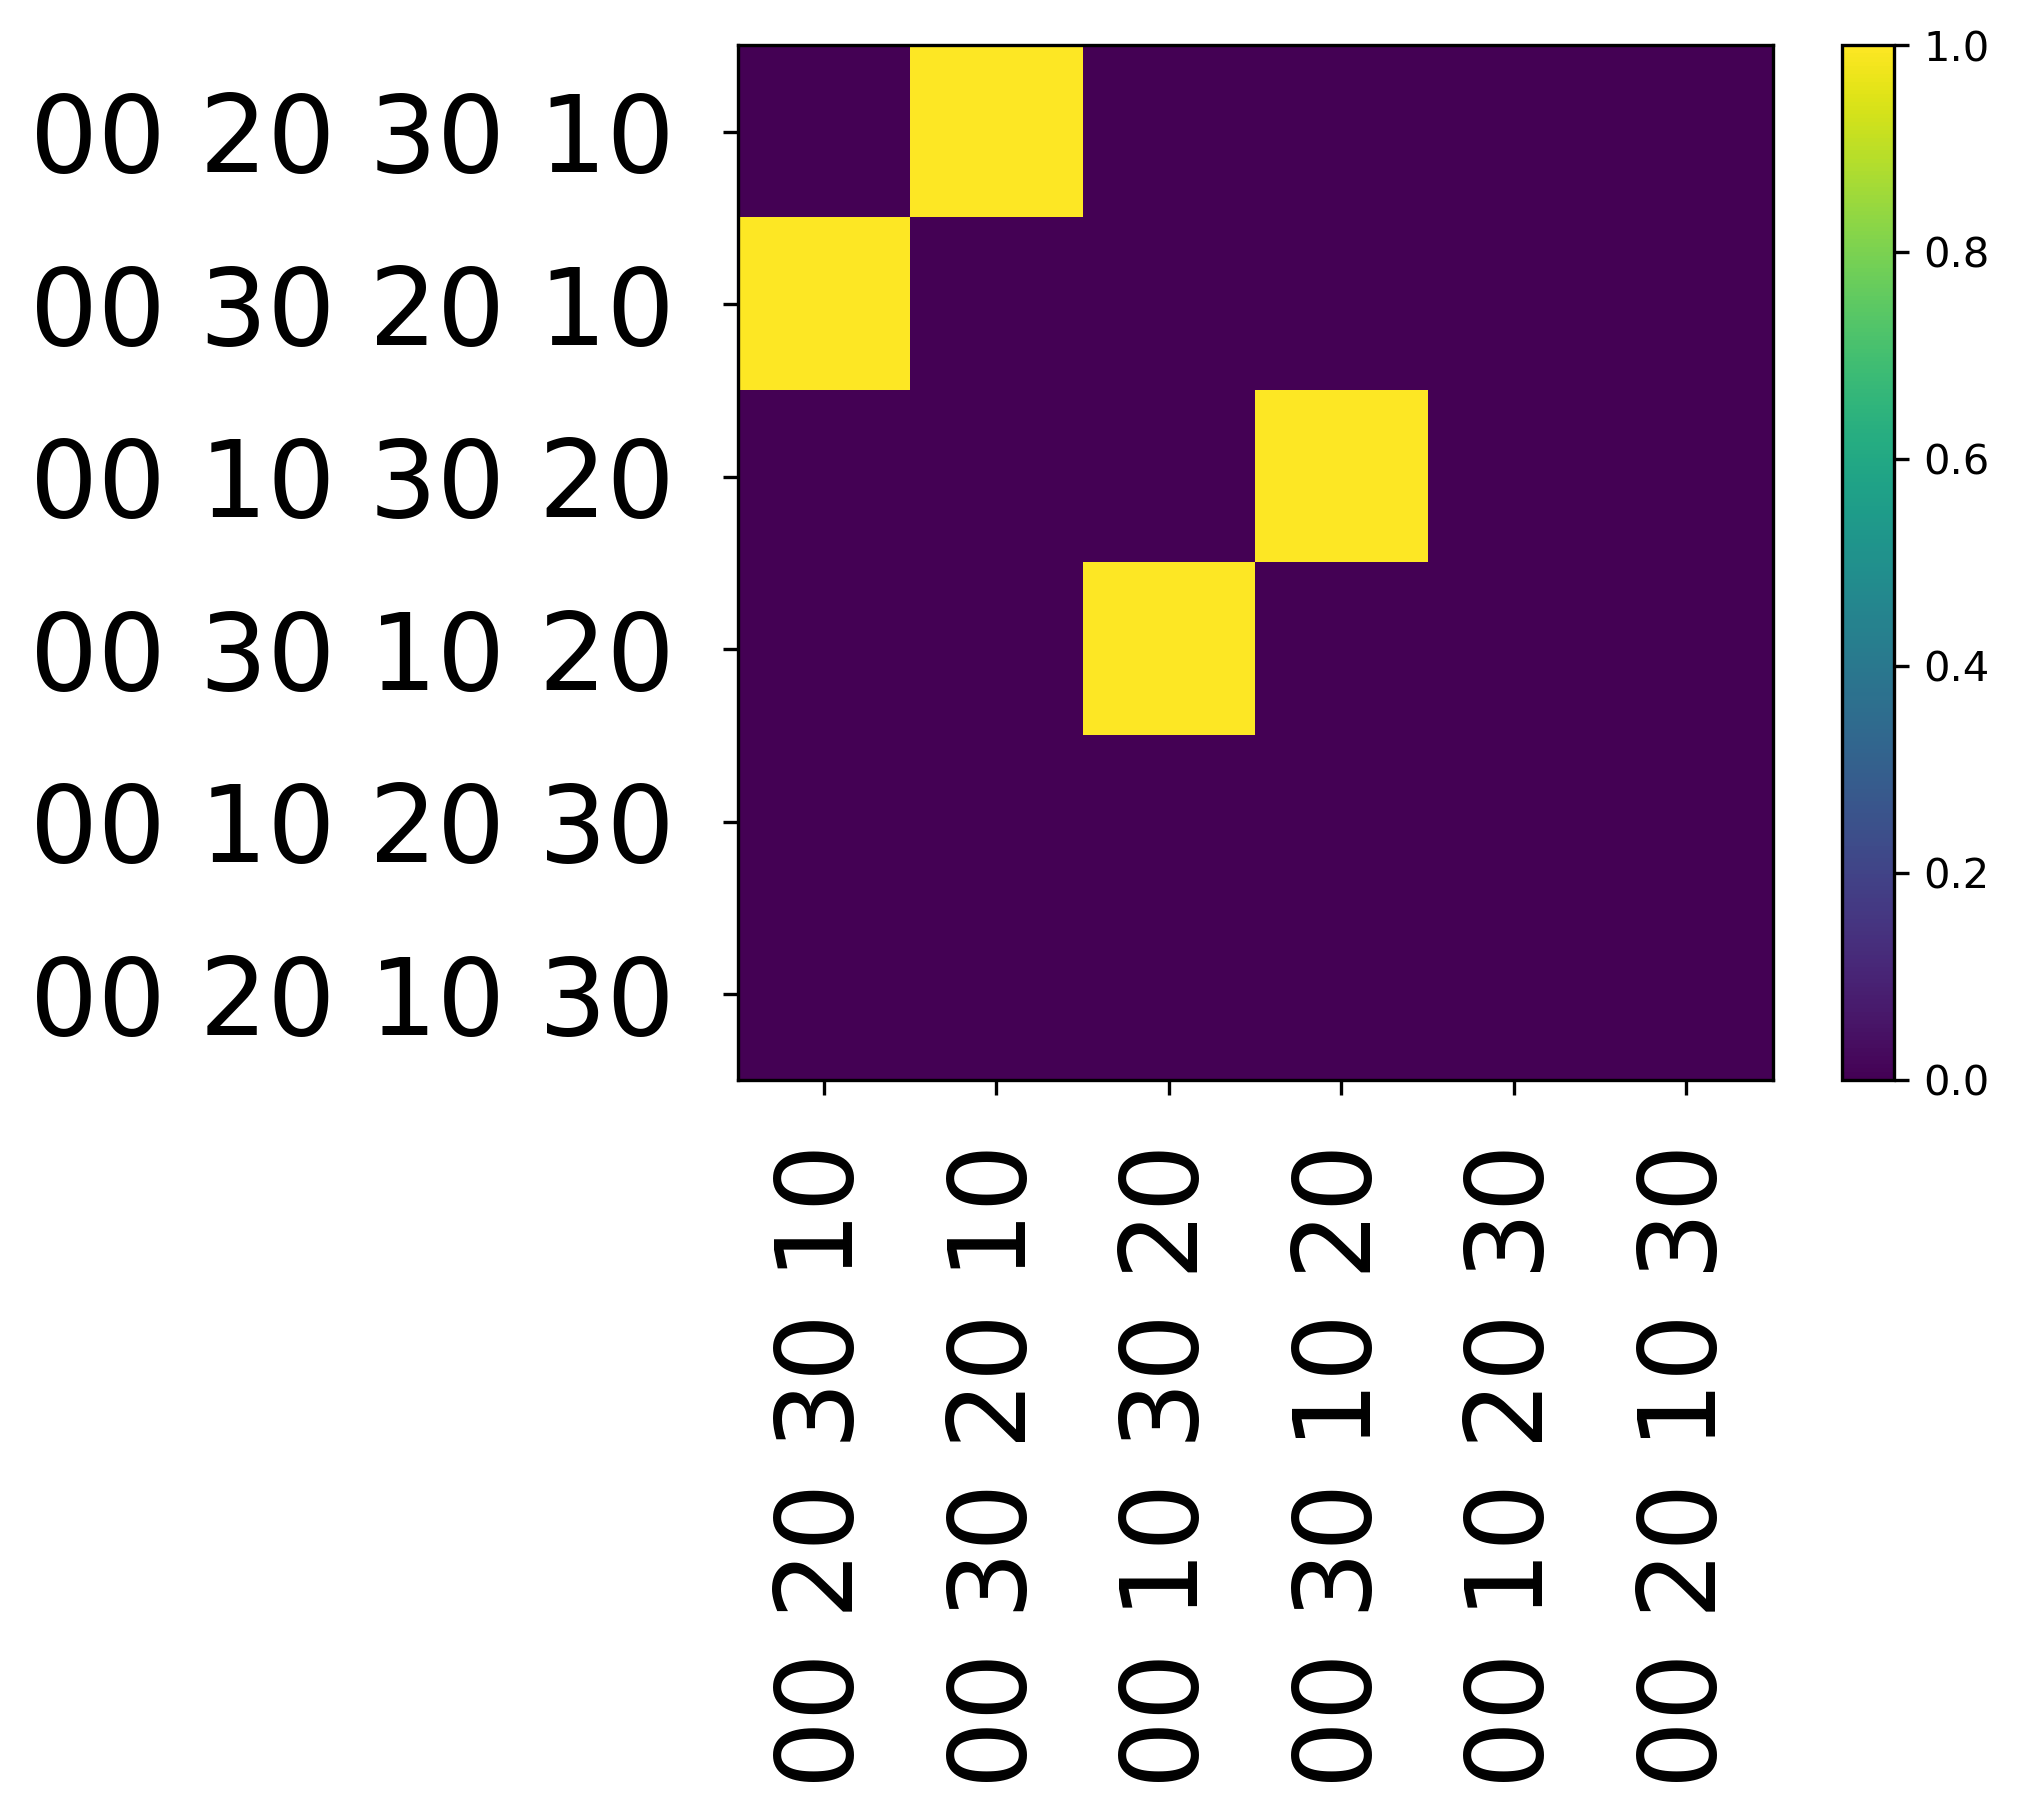

In [33]:
def next_entry(cycle, y):
    # print('cycle', cycle)
    return cycle[(cycle.index(y)+1)%len(cycle)]
# mpl.rcParams['figure.dpi'] = 300
y=str(n-1)+'0'
print(y)
standard = [cycle_to_standard(cycle) for cycle in cycles]
print(standard)
def get_y_diff(mat,y):
    diff_y = np.zeros((len(cycles), len(cycles)))
    for i1, cycle1 in enumerate(cycles):
        next1 = next_entry(cycle1, y)
        for i2, cycle2 in enumerate(cycles):
            next2 = next_entry(cycle2, y)
            if mat[i1, i2] != 0 and next1 != next2 and cycle1[-1] == y:
                diff_y[i1, i2] = mat[i1,i2]
                diff_y[i2, i1] = mat[i2,i1]
    return diff_y

def get_neg_part(mat,y):
    diff_neg = np.zeros((len(cycles), len(cycles)))
    for i1, cycle1 in enumerate(cycles):
        next1 = next_entry(cycle1, y)
        for i2, cycle2 in enumerate(cycles):
            next2 = next_entry(cycle2, y)
            if next1 != next2 and cycle1[-1] == cycle2[-1] != y:
                # print( dist(standard[i1], standard[i2]), end=" ")
                if dist(standard[i1], standard[i2])<=3:
                    diff_neg[i1, i2] = 1
                    diff_neg[i2, i1] = 1
    return diff_neg

diff_y = get_y_diff(adv_k, y)
diff_neg = get_neg_part(adv_k, y)
prod = diff_y@diff_y
visualize(prod)
visualize(diff_neg)
# print(np.where(diff_y<=0, 1, 0))
visualize(np.where((diff_neg == 1) & (prod >= 1), 1, 0), [better_labels]*2)


[-0.11909374 -0.0497627  -0.0455581  -0.0455581  -0.03791443 -0.03791443
 -0.03573618 -0.03573618 -0.0354014  -0.0328611  -0.01476169 -0.00488399
 -0.00488399  0.00122628  0.00163023  0.00172188  0.00172188  0.00206674
  0.00266838  0.00266838  0.00501352  0.00797545  0.00797545  0.0084542
  0.0084542   0.00982563  0.01153109  0.01229129  0.01229129  0.01259146
  0.01259146  0.01260668  0.01260668  0.01281153  0.01295218  0.02119797
  0.02191117  0.02191117  0.02324778  0.02324778  0.02358344  0.02536383
  0.02702315  0.02702315  0.0277561   0.0277561   0.02818427  0.02818427]


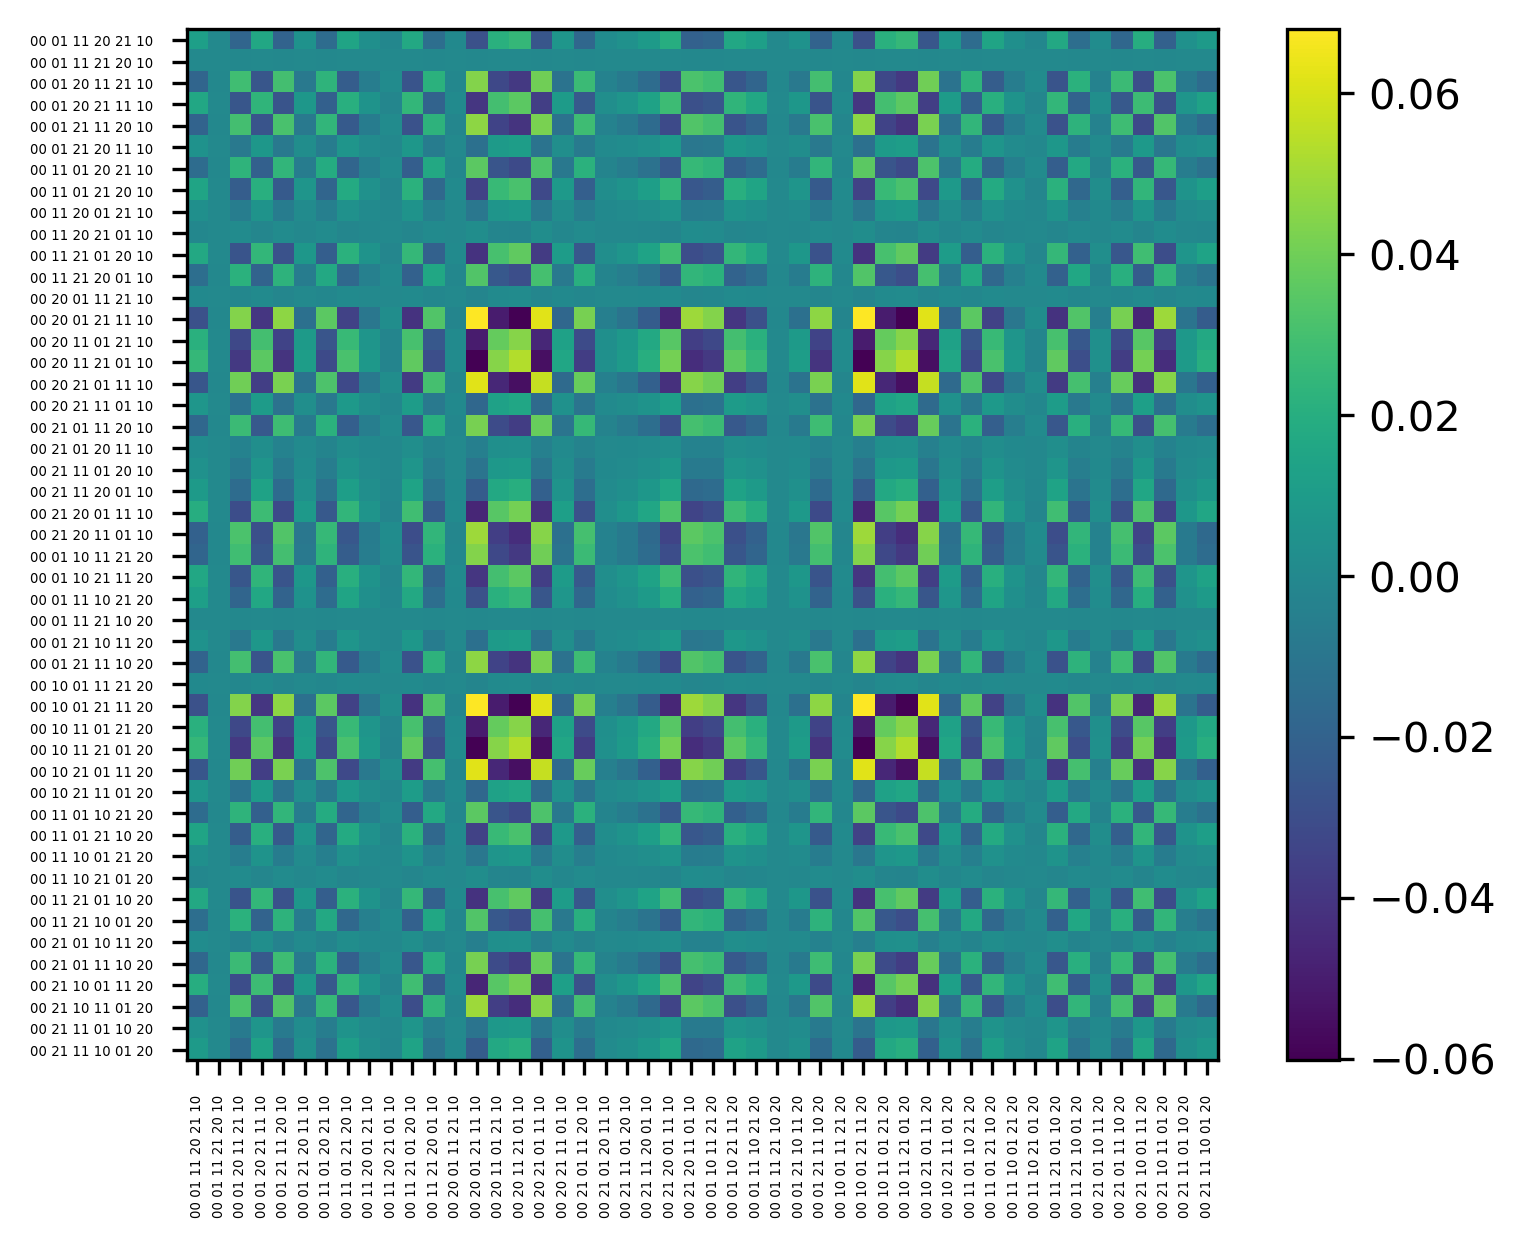

In [38]:
evals, evects = np.linalg.eigh(Lambda)
print(evals)
evects = np.real(evects)
vect = evects[:, -4]
visualize(np.outer(vect, vect), labels=[better_labels]*2)